In [ ]:

from datasets import load_dataset
from unsloth.chat_templates import get_chat_template

def load_chatml_dataset(data_path: str, tokenizer):

    # Load and convert dataset fomrat 
    ds = load_dataset("json", data_files=data_path, split="train")

    tokenizer = get_chat_template(
        tokenizer,
        chat_template="qwen3",
    )

    def formatting_prompts_func(examples):
      convos = examples["messages"]
      texts = [tokenizer.apply_chat_template(
         convo, tokenize = False, add_generation_prompt = False) for convo in convos]
      return { "text" : texts, }

    ds = ds.map(formatting_prompts_func,remove_columns=ds.column_names,batched = True)
    return ds


In [ ]:
import torch
from unsloth import FastLanguageModel
from transformers import TrainingArguments
from trl import SFTTrainer
from datasets import Dataset

# Model Config
MODEL_NAME = "unsloth/Qwen3-14B-unsloth-bnb-4bit"
DATASET_PATH = "training_data_cleaned.jsonl" 
OUTPUT_DIR = "./qwen_qlora_finetuned"
MAX_SEQ_LENGTH = 4096  # Giảm nếu gặp lỗi memory

# Load mô hình với QLoRA
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_NAME,
    max_seq_length=MAX_SEQ_LENGTH,
    dtype=torch.bfloat16,
    load_in_4bit=True, 
    token=None,  
)

print("Model loaded OK")

==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.57.3.
   \\   /|    NVIDIA RTX A6000. Num GPUs = 1. Max memory: 47.402 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded OK


In [ ]:
print("📂 Loading dataset...")

full_ds = load_chatml_dataset(
    data_path=DATASET_PATH,
    tokenizer=tokenizer,
    )
full_ds = full_ds.train_test_split(test_size=0.015, seed=42)
train_ds = full_ds["train"]
val_ds   = full_ds["test"]


📂 Loading dataset...


In [ ]:
full_ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 8458
    })
    test: Dataset({
        features: ['text'],
        num_rows: 129
    })
})

In [ ]:
print("🔧 Applying QLoRA adapters...")

# Cấu hình LoRA
model = FastLanguageModel.get_peft_model(
    model,
    r=32,  
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha=32,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)


🔧 Applying QLoRA adapters...


Unsloth 2026.1.2 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


In [ ]:
print("⚙️ Training arguments...")

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=2,  
    gradient_accumulation_steps=4,
    warmup_ratio=0.03,
    num_train_epochs=2,
    learning_rate=2e-4,
    fp16=False,
    bf16=True,

    eval_strategy="steps",   
    eval_steps=200,                
    load_best_model_at_end=True,   
    logging_steps=20,
    metric_for_best_model="eval_loss",

    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    save_strategy="steps",
    save_steps=200,
    save_total_limit=3,
    report_to="none",  
)

⚙️ Training arguments...


In [ ]:


# Tạo trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    dataset_text_field="text",
    max_seq_length=MAX_SEQ_LENGTH,
    args=training_args,
    packing=False,
)




Unsloth: Tokenizing ["text"] (num_proc=52):   0%|          | 0/8458 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=52):   0%|          | 0/129 [00:00<?, ? examples/s]

In [ ]:
print("🔍 Running baseline evaluation...")
trainer.evaluate()


Unsloth: Not an error, but Qwen3ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


🔍 Running baseline evaluation...


{'eval_loss': 3.173104763031006,
 'eval_model_preparation_time': 0.007,
 'eval_runtime': 14.3166,
 'eval_samples_per_second': 9.011,
 'eval_steps_per_second': 4.54}

In [ ]:
# Training
trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 8,458 | Num Epochs = 2 | Total steps = 2,116
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 128,450,560 of 14,896,757,760 (0.86% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss,Model Preparation Time
200,0.447500,0.438781,0.007000
400,0.365600,0.347120,0.007000
600,0.305700,0.293704,0.007000
800,0.242700,0.248026,0.007000
1000,0.224800,0.213128,0.007000
1200,0.170200,0.188559,0.007000
1400,0.171800,0.177855,0.007000
1600,0.158200,0.168927,0.007000
1800,0.157400,0.161045,0.007000
2000,0.150500,0.157985,0.007000


In [ ]:
print("💾 Saving LoRA adapters...")

# Lưu model
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

💾 Saving LoRA adapters...


('./qwen_qlora_finetuned/tokenizer_config.json',
 './qwen_qlora_finetuned/special_tokens_map.json',
 './qwen_qlora_finetuned/chat_template.jinja',
 './qwen_qlora_finetuned/vocab.json',
 './qwen_qlora_finetuned/merges.txt',
 './qwen_qlora_finetuned/added_tokens.json',
 './qwen_qlora_finetuned/tokenizer.json')

In [ ]:
from unsloth import FastLanguageModel
from peft import PeftModel
import torch

# 1. Load base model
model, tokenizer = FastLanguageModel.from_pretrained(
    "unsloth/Qwen3-14B-unsloth-bnb-4bit",
    load_in_4bit=True,
    max_seq_length=4096,
)

# 2. Load LoRA adapter
model = PeftModel.from_pretrained(
    model,
    "./qwen_qlora_finetuned",
)

model.eval()


==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.57.3.
   \\   /|    NVIDIA RTX A6000. Num GPUs = 1. Max memory: 47.402 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen3ForCausalLM(
      (model): Qwen3Model(
        (embed_tokens): Embedding(151936, 5120, padding_idx=151654)
        (layers): ModuleList(
          (0-5): 6 x Qwen3DecoderLayer(
            (self_attn): Qwen3Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.

In [ ]:
prompt = [
    {
        "role": "system",
        "content": (
            "Bạn là trợ lý tư vấn du lịch Việt Nam chuyên nghiệp. "
        )
    },
    {
        "role": "user",
        "content": "đi hà nội nên ăn gì?"
    }
]
inputs = tokenizer.apply_chat_template(
    prompt,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

attention_mask = torch.ones_like(inputs)

with torch.no_grad():
    outputs = model.generate(
        inputs,
        max_new_tokens=512,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
    )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


system
Bạn là trợ lý tư vấn du lịch Việt Nam chuyên nghiệp. 
user
đi hà nội nên ăn gì?
assistant
<think>

</think>

Thường quán rất đông nên quy tắc phục vụ khá nghiêm ngặt nhể. Bạn nên tập trung thưởng thức bát phở nóng hổi tại 49 Bát Đàn để cảm nhận trọn vẹn vị ngon.


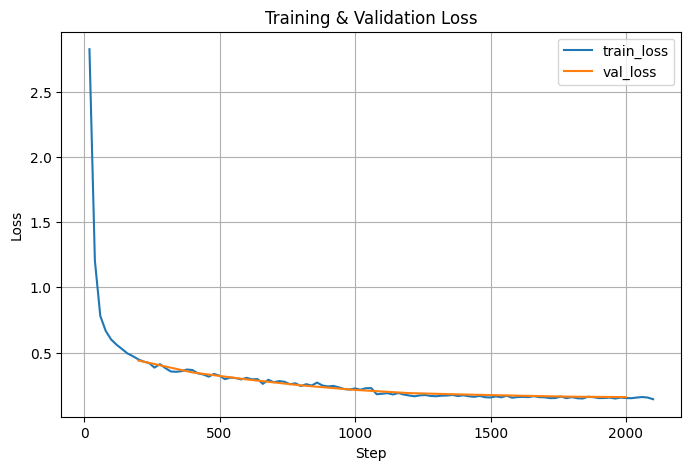

In [ ]:
import json
import matplotlib.pyplot as plt

with open("./qwen_qlora_finetuned/checkpoint-2116/trainer_state.json", "r") as f:
    state = json.load(f)

logs = state["log_history"]

train_steps, train_losses = [], []
val_steps, val_losses = [], []

for log in logs:
    if "loss" in log and "step" in log:
        train_steps.append(log["step"])
        train_losses.append(log["loss"])
    if "eval_loss" in log and "step" in log:
        val_steps.append(log["step"])
        val_losses.append(log["eval_loss"])

plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_losses, label="train_loss")
plt.plot(val_steps, val_losses, label="val_loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
